# Modeling step trends
*R.A. Collenteur (University of Graz), O. Ebbens (Artesia)*

In this Notebook the modeling of step trends in groundwater level time series is explored. Step trends can be used when a system change has taken place during the observation period, for example a lowering of the surrounding water levels. Here we model a groundwater level time series observed near the city of Eindhoven in the Netherlands that has undergone a structural change during the time of observation. The change has taken place in 2012, but unfortunately no observations are available for the period when the change was made. 

In [1]:
import pandas as pd
import pastas as ps

ps.set_log_level("ERROR")
ps.show_versions()

Python version: 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:37:09) 
[Clang 10.0.1 ]
Numpy version: 1.18.5
Scipy version: 1.4.0
Pandas version: 1.1.2
Pastas version: 0.16.0b
Matplotlib version: 3.1.3


## A model with precipitation and evaporation
First a model with only precipitation and potential evaporation as explanatory variables is created. It can be observed that the peak in the groundwater levels after 2012 lie about 0.5 meters lower that the peaks before 2012. This can also be observed by studying the model residuals, which show a different mean for the period before 2012 and after 2012.

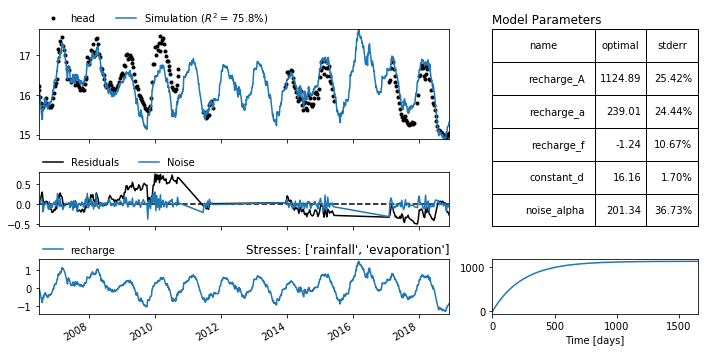

In [2]:
p = pd.read_csv("../data/nb18_rain.csv", index_col=0, parse_dates=True, squeeze=True)
e = pd.read_csv("../data/nb18_evap.csv", index_col=0, parse_dates=True, squeeze=True)
h = pd.read_csv("../data/nb18_head.csv", index_col=0, parse_dates=True, squeeze=True)

ml = ps.Model(h.iloc[::10])

sm = ps.RechargeModel(p, e, name="recharge", rfunc=ps.Exponential, recharge=ps.rch.Linear())
ml.add_stressmodel(sm)
ml.solve(report=False)

ml.plots.results(figsize=(10,5));

## Adding a step trend
Clearly, the model creating above has room for improvements. Since we know a system change has taken place around 2012, we can try and simulate this system change by adding a step trend. We do not know the absolute size of this step trend, only the time when it has taken place (1st of July 2012). The `StepModel` is available in Pastas to add a step trend to a model. This stress model does not require a independent time series, but a(indication of) the date of the system change instead. By deault the `StepModel` applies an instantaneous step in the groundwater level, using the `One` response function. it is however also possible to choose a more gradual change by applying another type of response function.

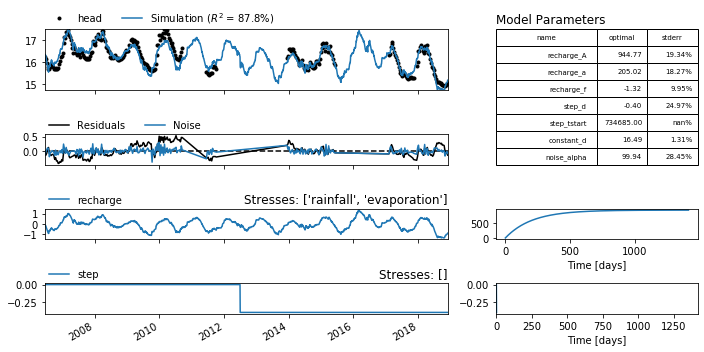

In [3]:
step = ps.StepModel(tstart=pd.Timestamp("2012-07-01"), name="step", up=None)
ml.add_stressmodel(step)
ml.solve(report=False)

ml.plots.results(figsize=(10,5));

## Diagnostic checking
In the following, the uncertainty of the estimated step trend is evaluated. Before we quantify the uncertainty, we perform some model diagnostic checks on the noise time series using `ps.plots.diagnostics()`. From this plot, we can say that the noise looks normally distributed and has no significant autocorrelation. Thus we may use the standard errors of the estimated parameters to quantify the uncertainty of the estimated step trend.

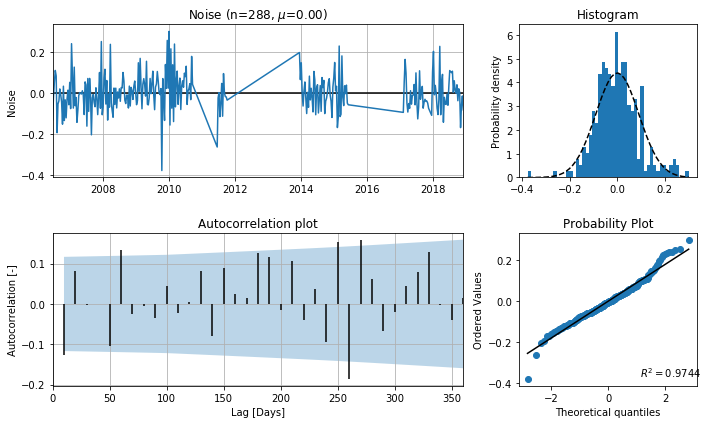

In [4]:
ml.plots.diagnostics();

## Uncertainty of step trend
Below we draw the 95% confidence interval of the step trend. We may use this confidence interval to interpret the results. For example, if we know or expect that the step trend is negative, we can reject the step trend from the model if the confidence interval also includes positive step trends. In this example this is not the case and the estimated step trend is always negative as expected.

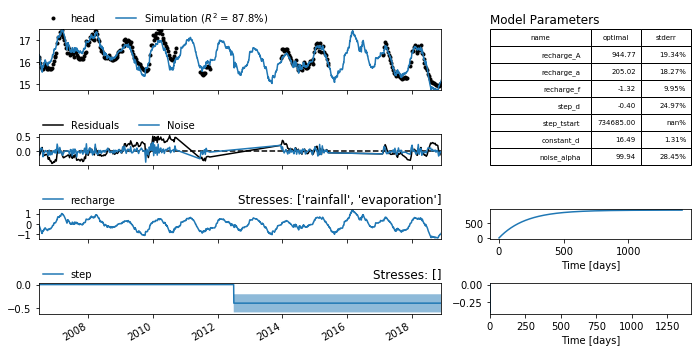

In [5]:
ci = ml.fit.ci_contribution("step", alpha=0.05)
axes = ml.plots.results(adjust_height=False, figsize=(10,5))
axes[-2].fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], zorder=-10, alpha=0.5);

## Notes
In principle it is possible to estimate the date of the change by varying the `step_tstart` parameter. In practice however estimating such a date is rather difficult and not recommended.   

## References
- Precipitation time series are taken from the KNMI weather station in Helmond
- Potential evaporation time series are taken from KNMI meteorological station in Eindhoven
- The groundwater level time series are taken from Dinoloket (B51G2150, Filter 1)